# Importing Libraries
# 
Import required libraries for Quantum and Classical computations. We use Pennylane for quantum simulations and TensorFlow for classical parts of the model.


In [1]:
import os
import pennylane as qml
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from pennylane.templates.embeddings import AmplitudeEmbedding, AngleEmbedding
from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from pennylane import AdamOptimizer, RMSPropOptimizer, QNGOptimizer
from sklearn.metrics import precision_score, recall_score, f1_score
from medmnist import OrganSMNIST, OrganAMNIST, OrganCMNIST, OCTMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predefined Model Structures
# 
This section defines some predefined model structures like PCA and autoencoders for feature reduction.


In [2]:
pca32 = ['pca32-1', 'pca32-2', 'pca32-3', 'pca32-4']
autoencoder32 = ['autoencoder32-1', 'autoencoder32-2', 'autoencoder32-3', 'autoencoder32-4']
pca30 = ['pca30-1', 'pca30-2', 'pca30-3', 'pca30-4']
autoencoder30 = ['autoencoder30-1', 'autoencoder30-2', 'autoencoder30-3', 'autoencoder30-4']
pca16 = ['pca16-1', 'pca16-2', 'pca16-3', 'pca16-4', 'pca16-compact']
autoencoder16 = ['autoencoder16-1', 'autoencoder16-2', 'autoencoder16-3', 'autoencoder16-4', 'autoencoder16-compact']
pca12 = ['pca12-1', 'pca12-2', 'pca12-3', 'pca12-4']
autoencoder12 = ['autoencoder12-1', 'autoencoder12-2', 'autoencoder12-3', 'autoencoder12-4']

In [3]:
from collections import Counter


def find_min_class_samples(labels):
    class_counts = Counter(labels)
    min_class_count = min(class_counts.values())
    print(f"Class counts: {class_counts}")
    print(f"Minimum number of samples among classes: {min_class_count}")
    return min_class_count, class_counts

# Data Loading and Processing
# 
This function loads the dataset, processes it by applying different techniques such as resizing or feature reduction using PCA or Autoencoder.


In [4]:
def data_load_and_process(dataset='OrganAMNIST', classes=None, feature_reduction='autoencoder8'):
    # Initialize variables
    x_train, y_train, x_test, y_test = None, None, None, None

    # Load the dataset
    if dataset == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'OrganAMNIST':
        train_dataset = OrganAMNIST(split="train", download=True)
        test_dataset = OrganAMNIST(split="test", download=True)
        val_dataset = OrganAMNIST(split="val", download=True)
    elif dataset == 'OrganCMNIST':
        train_dataset = OrganCMNIST(split="train", download=True)
        test_dataset = OrganCMNIST(split="test", download=True)
        val_dataset = OrganCMNIST(split="val", download=True)
    elif dataset == 'OrganSMNIST':
        train_dataset = OrganSMNIST(split="train", download=True)
        test_dataset = OrganSMNIST(split="test", download=True)
        val_dataset = OrganSMNIST(split="val", download=True)
    else:
        print(f"Dataset {dataset} not supported.")
        return None, None, None, None

    # For MNIST and FashionMNIST
    if dataset in ['mnist', 'fashion_mnist']:
        x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0  # Normalize the data

        # Filter the dataset for the specified classes if provided
        if classes is not None:
            train_filter = np.isin(y_train, classes)
            test_filter = np.isin(y_test, classes)
            x_train, y_train = x_train[train_filter], y_train[train_filter]
            x_test, y_test = x_test[test_filter], y_test[test_filter]

            # Map the labels to a new range (0 to number of classes - 1)
            label_map = {c: i for i, c in enumerate(classes)}
            y_train = np.vectorize(label_map.get)(y_train)
            y_test = np.vectorize(label_map.get)(y_test)

        # One-hot encode the labels
        num_classes = len(classes) if classes is not None else len(np.unique(y_train))
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)

    # For OrganMNIST datasets
    else:
        # Combine training and validation sets
        x_train = np.concatenate([train_dataset.imgs, val_dataset.imgs], axis=0)
        y_train = np.concatenate([train_dataset.labels, val_dataset.labels], axis=0).flatten()
        x_test = test_dataset.imgs
        y_test = test_dataset.labels.flatten()

        # Normalize images
        x_train = x_train[..., np.newaxis] / 255.0
        x_test = x_test[..., np.newaxis] / 255.0

        # Filter the dataset for the specified classes if provided
        if classes is not None:
            train_filter = np.isin(y_train, classes)
            test_filter = np.isin(y_test, classes)
            x_train, y_train = x_train[train_filter], y_train[train_filter]
            x_test, y_test = x_test[test_filter], y_test[test_filter]

            # Map the labels to a new range (0 to number of classes - 1)
            label_map = {c: i for i, c in enumerate(classes)}
            y_train = np.vectorize(label_map.get)(y_train)
            y_test = np.vectorize(label_map.get)(y_test)

        # Apply undersampling only if more than one class
        if len(np.unique(y_train)) > 1:
            # Apply undersampling
            min_class_count, class_counts = find_min_class_samples(y_train)

            print(f"Class counts before undersampling: {class_counts}")
            print(f"Minimum class count for undersampling: {min_class_count}")

            # Initialize lists to store balanced data
            x_train_balanced = []
            y_train_balanced = []

            # Undersample each class to the minimum class count
            classes_in_dataset = np.unique(y_train)
            for cls in classes_in_dataset:
                # Get indices of all samples in this class
                cls_indices = np.where(y_train == cls)[0]
                # Randomly select min_class_count samples
                selected_indices = np.random.choice(cls_indices, min_class_count, replace=False)
                # Append the selected samples to the balanced dataset
                x_train_balanced.append(x_train[selected_indices])
                y_train_balanced.append(y_train[selected_indices])

            # Concatenate the lists to form the balanced dataset
            x_train = np.concatenate(x_train_balanced, axis=0)
            y_train = np.concatenate(y_train_balanced, axis=0)

            # Shuffle the balanced training data
            shuffle_indices = np.random.permutation(len(y_train))
            x_train = x_train[shuffle_indices]
            y_train = y_train[shuffle_indices]

        # One-hot encode the labels
        num_classes = len(classes) if classes is not None else len(np.unique(y_train))
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)

    if feature_reduction == 'resize256':
        x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
        x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
        x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()

    elif feature_reduction == 'pca8' or feature_reduction in pca32 \
            or feature_reduction in pca30 or feature_reduction in pca16 or feature_reduction in pca12:

        x_train = tf.image.resize(x_train[:], (784, 1)).numpy()
        x_test = tf.image.resize(x_test[:], (784, 1)).numpy()
        x_train, x_test = tf.squeeze(x_train), tf.squeeze(x_test)

        if feature_reduction == 'pca8':
            pca = PCA(8)
        elif feature_reduction in pca32:
            pca = PCA(32)
        elif feature_reduction in pca30:
            pca = PCA(30)
        elif feature_reduction in pca16:
            pca = PCA(16)
        elif feature_reduction in pca12:
            pca = PCA(12)


        x_train = pca.fit_transform(x_train)
        x_test = pca.transform(x_test)

        # Rescale for angle embedding
        if feature_reduction == 'pca8' or feature_reduction == 'pca16-compact' or \
                feature_reduction in pca30 or feature_reduction in pca12:
            x_train, x_test = (x_train - x_train.min()) * (np.pi / (x_train.max() - x_train.min())),\
                              (x_test - x_test.min()) * (np.pi / (x_test.max() - x_test.min()))
        return x_train, x_test, y_train, y_test

    elif feature_reduction == 'autoencoder8' or feature_reduction in autoencoder32 \
            or feature_reduction in autoencoder30 or feature_reduction in autoencoder16 or feature_reduction in autoencoder12:
        if feature_reduction == 'autoencoder8':
            latent_dim = 8
        elif feature_reduction in autoencoder32:
            latent_dim = 32
        elif feature_reduction in autoencoder30:
            latent_dim = 30
        elif feature_reduction in autoencoder16:
            latent_dim = 16
        elif feature_reduction in autoencoder12:
            latent_dim = 12



        class Autoencoder(Model):
            def __init__(self, latent_dim):
                super(Autoencoder, self).__init__()
                self.latent_dim = latent_dim
                self.encoder = tf.keras.Sequential([
                    layers.Flatten(),
                    layers.Dense(latent_dim, activation='relu'),
                ])
                self.decoder = tf.keras.Sequential([
                    layers.Dense(784, activation='sigmoid'),
                    layers.Reshape((28, 28))
                ])

            def call(self, x):
                encoded = self.encoder(x)
                decoded = self.decoder(encoded)
                return decoded

        autoencoder = Autoencoder(latent_dim)

        autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
        autoencoder.fit(x_train, x_train,
                        epochs=10,
                        shuffle=True,
                        validation_data=(x_test, x_test))

        x_train, x_test = autoencoder.encoder(x_train).numpy(), autoencoder.encoder(x_test).numpy()

        # Rescale for Angle Embedding
        # Note this is not a rigorous rescaling method
        if feature_reduction == 'autoencoder8' or feature_reduction == 'autoencoder16-compact' or\
                feature_reduction in autoencoder30 or feature_reduction in autoencoder12:
            x_train, x_test = (x_train - x_train.min()) * (np.pi / (x_train.max() - x_train.min())), \
                              (x_test - x_test.min()) * (np.pi / (x_test.max() - x_test.min()))

        return x_train, x_test, y_train, y_test

# Quantum Circuit Definition
# Unitary Ansatze for Convolutional Layer


In [5]:
# Unitary Ansatze for Convolutional Layer
def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

# Pooling Layer

# def Pooling_ansatz1(params, wires): #2 params
#     qml.CRZ(params[0], wires=[wires[0], wires[1]])
#     qml.PauliX(wires=wires[0])
#     qml.CRX(params[1], wires=[wires[0], wires[1]])

def Pooling_ansatz1(params, wires):
    # print(f"Pooling_ansatz1 params: {params}")
    # if len(params) == 0:
        # raise ValueError("No parameters passed to Pooling_ansatz1")
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])





def Pooling_ansatz2(wires): #0 params
    qml.CRZ(wires=[wires[0], wires[1]])

def Pooling_ansatz3(*params, wires): #3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

# Hybrid State Preparation Methods
# 
Different state preparation methods, including angular hybrid embeddings for efficient use of qubits.

In [6]:
# 3 bits of information is embedded in 2 wires
def Angular_Hybrid_2(X, wires):
    qml.RY(X[0], wires=wires[0])

    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

# 15 bits of information is embedded in 4 wires
def Angular_Hybrid_4(X, wires):
    qml.RY(X[0], wires=wires[0])

    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])

# Embedding Function (Continued)
# 
The embedding function continues to map different embedding types (Amplitude, Angle, etc.) onto the quantum circuit.


In [7]:
def data_embedding(X, embedding_type='Amplitude'):
    if embedding_type == 'Amplitude':
        qml.templates.AmplitudeEmbedding(X, wires=range(8), normalize=True)
    elif embedding_type == 'Angle':
        qml.templates.AngleEmbedding(X, wires=range(8), rotation='Y')
    elif embedding_type == 'Angle-compact':
        qml.templates.AngleEmbedding(X[:8], wires=range(8), rotation='X')
        qml.templates.AngleEmbedding(X[8:16], wires=range(8), rotation='Y')


    # Hybrid Direct Embedding (HDE)
    elif embedding_type == 'Amplitude-Hybrid4-1' or embedding_type == 'Amplitude-Hybrid4-2' or \
            embedding_type == 'Amplitude-Hybrid4-3' or embedding_type == 'Amplitude-Hybrid4-4':
        X1 = X[:2 ** 4]
        X2 = X[2 ** 4:2 ** 5]
        norm_X1, norm_X2 = np.linalg.norm(X1), np.linalg.norm(X2)
        X1, X2 = X1 / norm_X1, X2 / norm_X2

        if embedding_type == 'Amplitude-Hybrid4-1':
            MottonenStatePreparation(X1, wires=[0, 1, 2, 3])
            MottonenStatePreparation(X2, wires=[4, 5, 6, 7])
        elif embedding_type == 'Amplitude-Hybrid4-2':
            MottonenStatePreparation(X1, wires=[0, 2, 4, 6])
            MottonenStatePreparation(X2, wires=[1, 3, 5, 7])
        elif embedding_type == 'Amplitude-Hybrid4-3':
            MottonenStatePreparation(X1, wires=[0, 1, 6, 7])
            MottonenStatePreparation(X2, wires=[2, 3, 4, 5])
        elif embedding_type == 'Amplitude-Hybrid4-4':
            MottonenStatePreparation(X1, wires=[0, 3, 4, 7])
            MottonenStatePreparation(X2, wires=[1, 2, 5, 6])

    elif embedding_type == 'Amplitude-Hybrid2-1' or embedding_type == 'Amplitude-Hybrid2-2' \
            or embedding_type == 'Amplitude-Hybrid2-3' or embedding_type == 'Amplitude-Hybrid2-4':
        X1 = X[:4]
        X2 = X[4:8]
        X3 = X[8:12]
        X4 = X[12:16]
        norm_X1, norm_X2, norm_X3, norm_X4 = np.linalg.norm(X1), np.linalg.norm(X2), np.linalg.norm(X3), np.linalg.norm(
            X4)
        X1, X2, X3, X4 = X1 / norm_X1, X2 / norm_X2, X3 / norm_X3, X4 / norm_X4

        if embedding_type == 'Amplitude-Hybrid2-1':
            MottonenStatePreparation(X1, wires=[0,1])
            MottonenStatePreparation(X2, wires=[2,3])
            MottonenStatePreparation(X3, wires=[4,5])
            MottonenStatePreparation(X4, wires=[6,7])
        elif embedding_type == 'Amplitude-Hybrid2-2':
            MottonenStatePreparation(X1, wires=[0,4])
            MottonenStatePreparation(X2, wires=[1,5])
            MottonenStatePreparation(X3, wires=[2,6])
            MottonenStatePreparation(X4, wires=[3,7])
        elif embedding_type == 'Amplitude-Hybrid2-3':
            MottonenStatePreparation(X1, wires=[0,7])
            MottonenStatePreparation(X2, wires=[1,6])
            MottonenStatePreparation(X3, wires=[2,5])
            MottonenStatePreparation(X4, wires=[3,4])
        elif embedding_type == 'Amplitude-Hybrid2-4':
            MottonenStatePreparation(X1, wires=[0,2])
            MottonenStatePreparation(X2, wires=[1,3])
            MottonenStatePreparation(X3, wires=[4,6])
            MottonenStatePreparation(X4, wires=[5,7])

    # Hybrid Angle Embedding (HAE)
    elif embedding_type == 'Angular-Hybrid4-1' or embedding_type == 'Angular-Hybrid4-2' or \
            embedding_type == 'Angular-Hybrid4-3' or embedding_type == 'Angular-Hybrid4-4':
        N = 15 # 15 classical data in 4 qubits
        X1 = X[:N]
        X2 = X[N:2*N]

        if embedding_type == 'Angular-Hybrid4-1':
            Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
            Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])
        elif embedding_type == 'Angular-Hybrid4-2':
            Angular_Hybrid_4(X1, wires=[0, 2, 4, 6])
            Angular_Hybrid_4(X2, wires=[1, 3, 5, 7])
        elif embedding_type == 'Angular-Hybrid4-3':
            Angular_Hybrid_4(X1, wires=[0, 1, 6, 7])
            Angular_Hybrid_4(X2, wires=[2, 3, 4, 5])
        elif embedding_type == 'Angular-Hybrid4-4':
            Angular_Hybrid_4(X1, wires=[0, 3, 4, 7])
            Angular_Hybrid_4(X2, wires=[1, 2, 5, 6])

    elif embedding_type == 'Angular-Hybrid2-1' or embedding_type == 'Angular-Hybrid2-2' \
            or embedding_type == 'Angular-Hybrid2-3' or embedding_type == 'Angular-Hybrid2-4':
        N = 3  # 3 classical bits in 2 qubits
        X1 = X[:N]
        X2 = X[N:2*N]
        X3 = X[2*N:3*N]
        X4 = X[3*N:4*N]

        if embedding_type == 'Angular-Hybrid2-1':
            Angular_Hybrid_2(X1, wires=[0,1])
            Angular_Hybrid_2(X2, wires=[2,3])
            Angular_Hybrid_2(X3, wires=[4,5])
            Angular_Hybrid_2(X4, wires=[6,7])
        elif embedding_type == 'Angular-Hybrid2-2':
            Angular_Hybrid_2(X1, wires=[0,4])
            Angular_Hybrid_2(X2, wires=[1,5])
            Angular_Hybrid_2(X3, wires=[2,6])
            Angular_Hybrid_2(X4, wires=[3,7])
        elif embedding_type == 'Angular-Hybrid2-3':
            Angular_Hybrid_2(X1, wires=[0,7])
            Angular_Hybrid_2(X2, wires=[1,6])
            Angular_Hybrid_2(X3, wires=[2,5])
            Angular_Hybrid_2(X4, wires=[3,4])
        elif embedding_type == 'Angular-Hybrid2-4':
            Angular_Hybrid_2(X1, wires=[0,2])
            Angular_Hybrid_2(X2, wires=[1,3])
            Angular_Hybrid_2(X3, wires=[4,6])
            Angular_Hybrid_2(X4, wires=[5,7])


# Quantum Convolutional Neural Network (QCNN)
# 
Define quantum convolution and pooling layers, and combine them to form a full QCNN structure.


In [8]:
# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
def conv_layer3(U, params):
    U(params, wires=[0,4])

# Quantum Circuits for Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])
def pooling_layer3(V, params):
    V(params, wires=[0,4])

def QCNN_structure(U, params, U_params):
    total_conv_params = U_params * 6  # Convolutional layer params
    total_pooling_params = 2 * 2  # Pooling layer params (2 params for each of 2 layers)
    
    # Ensure the params array is large enough
    assert len(params) >= (total_conv_params + total_pooling_params), "Insufficient parameters allocated."

    # Allocate parameters to convolutional layers
    param1 = params[0:U_params]
    param2 = params[U_params:2 * U_params]
    param3 = params[2 * U_params:3 * U_params]
    param4 = params[3 * U_params:4 * U_params]
    param5 = params[4 * U_params:5 * U_params]
    param6 = params[5 * U_params:total_conv_params]

    # Allocate parameters to pooling layers
    param7 = params[total_conv_params:total_conv_params + 2]  # Pooling layer 1
    param8 = params[total_conv_params + 2:total_conv_params + 4]  # Pooling layer 2

    # Apply conv and pooling layers
    conv_layer1(U, param1)
    conv_layer1(U, param2)
    pooling_layer1(Pooling_ansatz1, param7)

    conv_layer2(U, param3)
    conv_layer2(U, param4)
    pooling_layer2(Pooling_ansatz1, param8)

    conv_layer3(U, param5)
    conv_layer3(U, param6)


# QCNN Execution and Output Processing
# 
Execute the QCNN and scale the output. It also includes a fully connected classical neural network to process the quantum output.


In [9]:
dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev)
def QCNN(X, params, U, U_params, embedding_type='Amplitude'):
    # Data Embedding
    data_embedding(X, embedding_type=embedding_type)

    # Quantum Convolutional Neural Network
    if U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)
    else:
        print("Invalid Unitary Ansatze")
        return False

    taken_qubits = [0, 4]  # qubits taken forward
    lost_qubits = [7, 1]   # qubits measured and lost
    probabilities_taken = qml.probs(wires=taken_qubits)
    probabilities_lost = qml.probs(wires=lost_qubits)

    return probabilities_taken, probabilities_lost, 



def scaled_output(probabilities):
    probabilities = np.array(probabilities)  # Convert to numpy array
    #print(f"Scaled Output Dimensions: {probabilities.shape}")
    return (probabilities * 4) - 2  # Scale to range -2 to 2

In [10]:
class FullyConnectedLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / (input_dim + output_dim))  # Xavier initialization
        self.bias = np.zeros(output_dim)
        #print(f"Initialized Weights Dimensions: {self.weights.shape}")
        #print(f"Initialized Bias Dimensions: {self.bias.shape}")
    
    def forward(self, inputs):
        #print(f"Input Dimensions: {inputs.shape}")
        z = np.dot(self.weights, inputs) + self.bias
        #print(f"Z (Weighted Sum) Dimensions: {z.shape}")
        output = np.tanh(z)
        #print(f"Output Dimensions: {output.shape}")
        return output
    
    def get_params(self):
        return np.concatenate([self.weights.flatten(), self.bias])

    def set_params(self, params):
        weight_size = self.weights.size
        self.weights = params[:weight_size].reshape(self.weights.shape)
        self.bias = params[weight_size:weight_size + self.bias.size]


class HiddenLayer:
    def __init__(self, input_dim, hidden_dim):
        self.weights = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / (input_dim + hidden_dim))
        self.bias = np.zeros(hidden_dim)
        #print(f"Initialized Hidden Layer Weights Dimensions: {self.weights.shape}")
        #print(f"Initialized Hidden Layer Bias Dimensions: {self.bias.shape}")
    
    def forward(self, inputs):
        #print(f"Hidden Layer Input Dimensions: {inputs.shape}")
        z = np.dot(self.weights, inputs) + self.bias
        #print(f"Hidden Layer Output Dimensions: {z.shape}")
        return np.tanh(z)
    
    def get_params(self):
        return np.concatenate([self.weights.flatten(), self.bias])

    def set_params(self, params):
        weight_size = self.weights.size
        self.weights = params[:weight_size].reshape(self.weights.shape)
        self.bias = params[weight_size:weight_size + self.bias.size]

class FinalLayer:
    def __init__(self, hidden_dim, output_dim):
        self.weights = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / (hidden_dim + output_dim))
        self.bias = np.zeros(output_dim)
        #print(f"Initialized Final Layer Weights Dimensions: {self.weights.shape}")
        #print(f"Initialized Final Layer Bias Dimensions: {self.bias.shape}")
    
    def forward(self, inputs):
        #print(f"Final Layer Input Dimensions: {inputs.shape}")
        z = np.dot(self.weights, inputs) + self.bias
        #print(f"Final Layer Z (Weighted Sum) Dimensions: {z.shape}")
        output = np.tanh(z)
        #print(f"Final Layer Output Dimensions: {output.shape}")
        return output
    
    def get_params(self):
        return np.concatenate([self.weights.flatten(), self.bias])

    def set_params(self, params):
        weight_size = self.weights.size
        self.weights = params[:weight_size].reshape(self.weights.shape)
        self.bias = params[weight_size:weight_size + self.bias.size]


# Example of how to use these classes
final_layer = FinalLayer(hidden_dim=16, output_dim=6) 


def dot_product(neurons_taken, neurons_lost):
    # print(f"Dot Product Input Neurons Taken Dimensions: {neurons_taken.shape}")
    # print(f"Dot Product Input Neurons Lost Dimensions: {neurons_lost.shape}")
    result = np.multiply(neurons_taken, neurons_lost)
    # print(f"Dot Product Output Dimensions: {result.shape}")
    return result


def process_neurons(probabilities_taken, probabilities_lost, classical_params):
    # Initialize the fully connected layers
    fc_layer_taken = FullyConnectedLayer(input_dim=4, output_dim=4)
    hidden_layer_lost = HiddenLayer(input_dim=4, hidden_dim=16)
    final_layer_lost = FinalLayer(hidden_dim=16, output_dim=4)

    # Set the classical parameters
    fc_layer_taken.set_params(classical_params[:fc_layer_taken.get_params().size])
    hidden_layer_lost.set_params(classical_params[fc_layer_taken.get_params().size:fc_layer_taken.get_params().size + hidden_layer_lost.get_params().size])
    final_layer_lost.set_params(classical_params[-final_layer_lost.get_params().size:])

    # Scale the probabilities
    scaled_values_taken = scaled_output(probabilities_taken)
    scaled_values_lost = scaled_output(probabilities_lost)

    # Process the scaled values through their respective layers
    output_neurons_taken = fc_layer_taken.forward(scaled_values_taken)
    hidden_output = hidden_layer_lost.forward(scaled_values_lost)
    output_neurons_lost = final_layer_lost.forward(hidden_output)

    # Combine the outputs from the two sets of neurons
    combined_output = dot_product(output_neurons_taken, output_neurons_lost)

    return combined_output

In [11]:
def plot_training_loss_history(loss_history):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_same_graph(train_accuracy_history, test_accuracy_history):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracy_history, label='Training Accuracy', color='blue')
    plt.plot(test_accuracy_history, label='Test Accuracy', color='green')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Training and Evaluation
# 
Functions for training the model, calculating accuracy, and plotting metrics. Includes methods to save and load the best model parameters.


In [12]:
def accuracy_test(predictions, labels):
    correct = 0
    for i, (p, l) in enumerate(zip(predictions, labels)):
        # print(f"Iteration {i}: Prediction: {p}, Label: {l}")
        if np.argmax(p) == np.argmax(l):
            correct += 1
    return correct / len(labels)

def square_loss(labels, predictions):
    labels = np.array(labels)  # Convert labels to numpy array
    predictions = np.array(predictions)  # Convert predictions to numpy array
    loss = np.mean((labels - predictions) ** 2)
    return loss



def cross_entropy(labels, predictions):
    labels = np.array(labels)
    predictions = np.array(predictions)
    return -np.sum(labels * np.log(predictions + 1e-9)) / len(labels)


steps = 1201
learning_rate = 0.01
batch_size = 25



def save_best_model(params, filename="mnist[0,1,2,3]+8+[7,1] best_model.npz"):
    """Save the best model's parameters to a file."""
    np.savez(filename, params=params)
    print(f"Model saved as {filename}")

def load_best_model(filename="best_model.npz"):
    """Load the model's parameters from a file."""
    if os.path.exists(filename):
        data = np.load(filename)
        return data['params']
    else:
        print(f"No model file found at {filename}")
        return None

def circuit_training(X_train, Y_train, X_test, Y_test, U, U_params, embedding_type, circuit, cost_fn, hidden_dim=16):
    total_conv_params = U_params * 6  # 6 convolutional layers
    total_pooling_params = 2 * 2  # 2 pooling layers, each with 2 parameters
    total_quantum_params = total_conv_params + total_pooling_params  # Total quantum params

    total_classical_params = (
        FullyConnectedLayer(4, 4).get_params().size +
        HiddenLayer(4, 16).get_params().size +
        FinalLayer(16, 4).get_params().size
    )

    # Initialize all parameters
    params = np.random.randn(total_quantum_params + total_classical_params)
    
    optimizer = RMSPropOptimizer(stepsize=0.01)
    loss_history = []
    train_accuracy_history = []  # List to store training accuracy values
    test_accuracy_history = []   # List to store test accuracy values

    best_accuracy = 0  # Track the best test accuracy
    best_params = None  # Store the best model's parameters

    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), batch_size)
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        # Optimizer step and cost calculation
        params, cost_new = optimizer.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, embedding_type, circuit), params)
        
        # Record loss every 10 steps
        if it % 10 == 0:
            loss_history.append(cost_new)
            print(f"Iteration: {it}, Loss: {cost_new}")

        # Calculate accuracy every 50 steps for both training and test sets
        if it % 50 == 0 and it != 0:
            # Calculate training accuracy
            train_predictions = []
            for x in X_batch:
                probabilities_taken, probabilities_lost = QCNN(x, params[:total_quantum_params], U, U_params, embedding_type)
                combined_output = process_neurons(probabilities_taken, probabilities_lost, params[total_quantum_params:])
                train_predictions.append(combined_output)
            
            train_accuracy = accuracy_test(train_predictions, Y_batch)
            train_accuracy_history.append(train_accuracy)  # Append training accuracy to history
            print(f"Iteration: {it}, Training Accuracy: {train_accuracy}")

            # Calculate test accuracy
            test_predictions = []
            for x in X_test:
                probabilities_taken, probabilities_lost = QCNN(x, params[:total_quantum_params], U, U_params, embedding_type)
                combined_output = process_neurons(probabilities_taken, probabilities_lost, params[total_quantum_params:])
                test_predictions.append(combined_output)
            
            test_accuracy = accuracy_test(test_predictions, Y_test)
            test_accuracy_history.append(test_accuracy)  # Append test accuracy to history
            print(f"Iteration: {it}, Test Accuracy: {test_accuracy}")

            # If the current test accuracy is the best we've seen, save the model
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_params = params.copy()  # Store the best parameters
                save_best_model(best_params)  # Save the best parameters to a file

    # Plot training loss, training accuracy, and test accuracy separately
    plot_training_loss_history(loss_history)
    plot_accuracy_same_graph(train_accuracy_history, test_accuracy_history)
    
    return loss_history, train_accuracy_history, test_accuracy_history, best_params



def cost(params, X_batch, Y_batch, U, U_params, embedding_type, circuit):
    total_conv_params = U_params * 6
    total_pooling_params = 2 * 2
    quantum_params = params[:total_conv_params + total_pooling_params]
    classical_params = params[total_conv_params + total_pooling_params:]

    # print(f"Quantum params size: {quantum_params.size}, Classical params size: {classical_params.size}")

    predictions = []
    for x in X_batch:
        probabilities_taken, probabilities_lost = QCNN(x, quantum_params, U, U_params, embedding_type)
        # print(f"Probabilities taken: {probabilities_taken}, Probabilities lost: {probabilities_lost}")
        combined_output = process_neurons(probabilities_taken, probabilities_lost, classical_params)
        predictions.append(combined_output)

    return square_loss(Y_batch, predictions)

Benchmarking

In [13]:
def Encoding_to_Embedding(Encoding):
    # Amplitude Embedding / Angle Embedding
    if Encoding == 'resize256':
        Embedding = 'Amplitude'
    elif Encoding == 'pca8':
        Embedding = 'Angle'
    elif Encoding == 'autoencoder8':
        Embedding = 'Angle'

    # Amplitude Hybrid Embedding
    # 4 qubit block
    elif Encoding == 'pca32-1':
        Embedding = 'Amplitude-Hybrid4-1'
    elif Encoding == 'autoencoder32-1':
        Embedding = 'Amplitude-Hybrid4-1'

    elif Encoding == 'pca32-2':
        Embedding = 'Amplitude-Hybrid4-2'
    elif Encoding == 'autoencoder32-2':
        Embedding = 'Amplitude-Hybrid4-2'

    elif Encoding == 'pca32-3':
        Embedding = 'Amplitude-Hybrid4-3'
    elif Encoding == 'autoencoder32-3':
        Embedding = 'Amplitude-Hybrid4-3'

    elif Encoding == 'pca32-4':
        Embedding = 'Amplitude-Hybrid4-4'
    elif Encoding == 'autoencoder32-4':
        Embedding = 'Amplitude-Hybrid4-4'

    # 2 qubit block
    elif Encoding == 'pca16-1':
        Embedding = 'Amplitude-Hybrid2-1'
    elif Encoding == 'autoencoder16-1':
        Embedding = 'Amplitude-Hybrid2-1'

    elif Encoding == 'pca16-2':
        Embedding = 'Amplitude-Hybrid2-2'
    elif Encoding == 'autoencoder16-2':
        Embedding = 'Amplitude-Hybrid2-2'

    elif Encoding == 'pca16-3':
        Embedding = 'Amplitude-Hybrid2-3'
    elif Encoding == 'autoencoder16-3':
        Embedding = 'Amplitude-Hybrid2-3'

    elif Encoding == 'pca16-4':
        Embedding = 'Amplitude-Hybrid2-4'
    elif Encoding == 'autoencoder16-4':
        Embedding = 'Amplitude-Hybrid2-4'

    # Angular HybridEmbedding
    # 4 qubit block
    elif Encoding == 'pca30-1':
        Embedding = 'Angular-Hybrid4-1'
    elif Encoding == 'autoencoder30-1':
        Embedding = 'Angular-Hybrid4-1'

    elif Encoding == 'pca30-2':
        Embedding = 'Angular-Hybrid4-2'
    elif Encoding == 'autoencoder30-2':
        Embedding = 'Angular-Hybrid4-2'

    elif Encoding == 'pca30-3':
        Embedding = 'Angular-Hybrid4-3'
    elif Encoding == 'autoencoder30-3':
        Embedding = 'Angular-Hybrid4-3'

    elif Encoding == 'pca30-4':
        Embedding = 'Angular-Hybrid4-4'
    elif Encoding == 'autoencoder30-4':
        Embedding = 'Angular-Hybrid4-4'

    # 2 qubit block
    elif Encoding == 'pca12-1':
        Embedding = 'Angular-Hybrid2-1'
    elif Encoding == 'autoencoder12-1':
        Embedding = 'Angular-Hybrid2-1'

    elif Encoding == 'pca12-2':
        Embedding = 'Angular-Hybrid2-2'
    elif Encoding == 'autoencoder12-2':
        Embedding = 'Angular-Hybrid2-2'

    elif Encoding == 'pca12-3':
        Embedding = 'Angular-Hybrid2-3'
    elif Encoding == 'autoencoder12-3':
        Embedding = 'Angular-Hybrid2-3'

    elif Encoding == 'pca12-4':
        Embedding = 'Angular-Hybrid2-4'
    elif Encoding == 'autoencoder12-4':
        Embedding = 'Angular-Hybrid2-4'

    # Two Gates Compact Encoding
    elif Encoding == 'pca16-compact':
        Embedding = 'Angle-compact'
    elif Encoding == 'autoencoder16-compact':
        Embedding = 'Angle-compact'
    return Embedding




# Benchmarking
# 
This function allows for benchmarking the performance of the model with different unitary ansatzes and embedding techniques.


100%|██████████| 38247708/38247708 [00:17<00:00, 2156444.91it/s]


Using downloaded and verified file: C:\Users\20201067.BRACU\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\20201067.BRACU\.medmnist\organamnist.npz
Class counts: Counter({tensor(2, requires_grad=True): 4952, tensor(3, requires_grad=True): 3560, tensor(0, requires_grad=True): 2277, tensor(1, requires_grad=True): 1866})
Minimum number of samples among classes: 1866
Class counts before undersampling: Counter({tensor(2, requires_grad=True): 4952, tensor(3, requires_grad=True): 3560, tensor(0, requires_grad=True): 2277, tensor(1, requires_grad=True): 1866})
Minimum class count for undersampling: 1866
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0734 - val_loss: 0.0540
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0464 - val_loss: 0.0502
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0436 - val_loss: 0.0474
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0419 - val_loss: 0.0468
Epoch 5/10
234/234 ━━━━━━━━━━

d:\thesis_summer\files\qmlenv\lib\site-packages\autograd\numpy\numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Iteration: 0, Loss: 0.34688892950961986
Iteration: 10, Loss: 0.23199812627655267
Iteration: 20, Loss: 0.14305574562622345
Iteration: 30, Loss: 0.15552274911255898
Iteration: 40, Loss: 0.12882521881214748
Iteration: 50, Loss: 0.11951128475240233
Iteration: 50, Training Accuracy: 0.88
Iteration: 50, Test Accuracy: 0.7015414258188825
Model saved as mnist[0,1,2,3]+8+[7,1] best_model.npz
Iteration: 60, Loss: 0.1429599296824096
Iteration: 70, Loss: 0.10728487105983776
Iteration: 80, Loss: 0.1499006840411768
Iteration: 90, Loss: 0.1354236432108706
Iteration: 100, Loss: 0.12143710217611543
Iteration: 100, Training Accuracy: 0.8
Iteration: 100, Test Accuracy: 0.7221579961464355
Model saved as mnist[0,1,2,3]+8+[7,1] best_model.npz
Iteration: 110, Loss: 0.12030943964228498
Iteration: 120, Loss: 0.09195956995591753
Iteration: 130, Loss: 0.10313975850545304
Iteration: 140, Loss: 0.11244913736377184
Iteration: 150, Loss: 0.1233756913268529
Iteration: 150, Training Accuracy: 0.72
Iteration: 150, Test

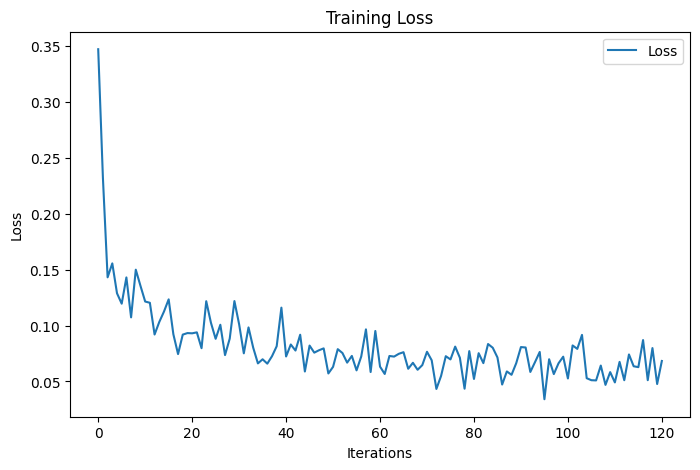

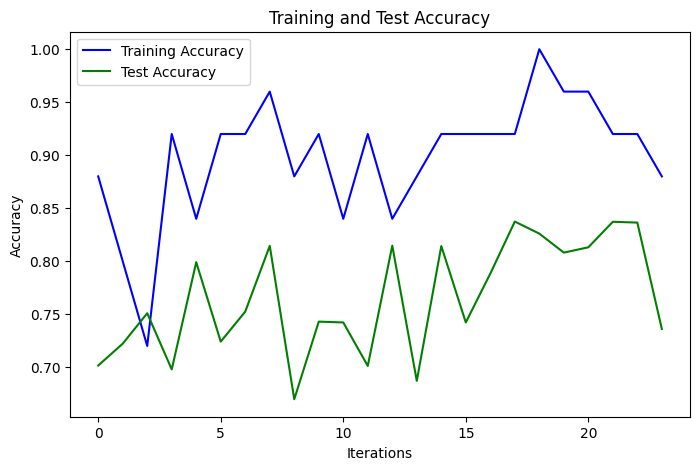

Train Accuracy: 0.8687031082529475
Train Precision: 0.8766888924448026, Train Recall: 0.8687031082529475, Train F1: 0.8669205417110658


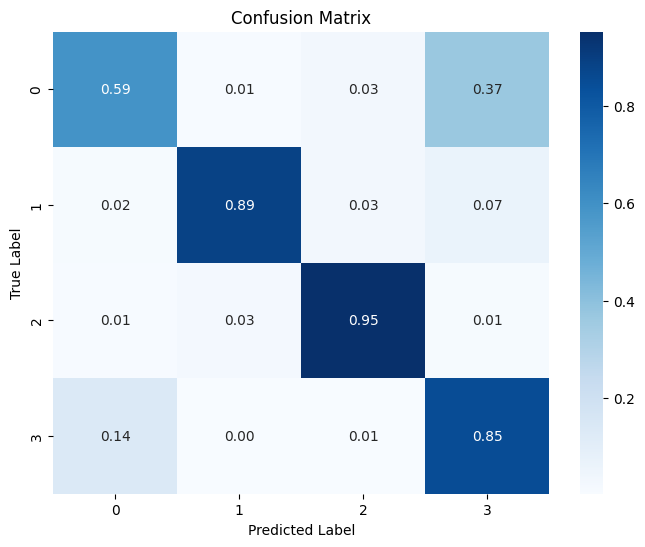

Test Accuracy: 0.8373795761078998
Test Precision: 0.8374073005012024, Test Recall: 0.8373795761078998, Test F1: 0.8353772285676405


In [14]:
def calculate_metrics(predictions, labels):
    # Convert predictions and labels to the appropriate format
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    return precision, recall, f1



def plot_confusion_matrix(predictions, labels):
    # Convert probabilities to class predictions
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def Benchmarking(dataset, classes, Unitaries, U_num_params, Encodings):
    for U, U_params in zip(Unitaries, U_num_params):
        for Encoding in Encodings:
            X_train, X_test, Y_train, Y_test = data_load_and_process(dataset, classes=classes, feature_reduction=Encoding)

            print(f"Training {U} with {Encoding} encoding")

            # Unpack all four return values: loss history, train/test accuracy history, and trained parameters
            loss_history, train_accuracy_history, test_accuracy_history, trained_params = circuit_training(
                X_train, Y_train, X_test, Y_test, U, U_params, Encoding_to_Embedding(Encoding), 'QCNN', square_loss
            )

            total_conv_params = U_params * 6  # 6 convolutional layers
            total_pooling_params = 2 * 2  # 2 pooling layers
            total_quantum_params = total_conv_params + total_pooling_params

            quantum_params = trained_params[:total_quantum_params]
            classical_params = trained_params[total_quantum_params:]

            # Calculate Train Metrics
            train_predictions = []
            for x in X_train:
                probabilities_taken, probabilities_lost = QCNN(x, quantum_params, U, U_params, Encoding_to_Embedding(Encoding))
                combined_output = process_neurons(probabilities_taken, probabilities_lost, classical_params)
                train_predictions.append(combined_output)

            train_accuracy = accuracy_test(train_predictions, Y_train)
            train_precision, train_recall, train_f1 = calculate_metrics(train_predictions, Y_train)
            print(f"Train Accuracy: {train_accuracy}")
            print(f"Train Precision: {train_precision}, Train Recall: {train_recall}, Train F1: {train_f1}")

            # Calculate Test Metrics
            test_predictions = []
            for x in X_test:
                probabilities_taken, probabilities_lost = QCNN(x, quantum_params, U, U_params, Encoding_to_Embedding(Encoding))
                combined_output = process_neurons(probabilities_taken, probabilities_lost, classical_params)
                test_predictions.append(combined_output)
                
            plot_confusion_matrix(test_predictions, Y_test)
            test_accuracy = accuracy_test(test_predictions, Y_test)
            test_precision, test_recall, test_f1 = calculate_metrics(test_predictions, Y_test)
            print(f"Test Accuracy: {test_accuracy}")
            print(f"Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1: {test_f1}")


Unitaries = ['U_SU4']
U_num_params = [15]
Encodings = ['autoencoder8']
# Encodings = ['resize256']
dataset = 'OrganAMNIST'
classes = [0, 3, 7, 9]   
results = Benchmarking(dataset, classes, Unitaries, U_num_params, Encodings)